In [1]:
import pandas as pd
import cv2
import geopandas as gpd
import rasterio
import rasterio.mask
import geopandas as gpd
from shapely.geometry import mapping
import cv2
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm_notebook 

from rasterio.features import rasterize
import rasterio.plot
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# raster_path = "/home/user/projects/africa_starving/data/images/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_TCI.jp2"
train_df = gpd.read_file("/home/user/projects/africa_data/data/train/train/train_repr.geojson")
# raster_path = "/mnt/storage_4tb/ymi/crop_detection/Africa/data/images/2017-01-01/full/TCI.jp2"
root_dir = "/home/user/projects/africa_data/Africa/data/images"

# root_dir = "/mnt/storage_4tb/ymi/crop_detection/Africa/data/images"
dates = os.listdir(root_dir)
raster_path = "/mnt/storage_4tb/ymi/crop_detection/Africa/data/images/2017-01-01/full/ndvi.tif"
# train_df = gpd.read_file("/mnt/storage_4tb/ymi/crop_detection/train/train/train_repr.geojson")

In [8]:
srcs = []
for i in dates:
    raster_path = os.path.join(root_dir, i, "full/ndvi.tif")
    srcs.append(rasterio.open(raster_path, 'r'))
imgs = []
masks_bin = []
labels = []
for num, row in tqdm_notebook(train_df.iterrows()):
    try:
        cur_ims = []
        for src in srcs:
            masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=-10000, filled=False)
            mask = masked_image.mask[0]
            
            #print(mask.shape)
            img_to_test = rasterio.plot.reshape_as_image(masked_image.data)
            img_to_test[img_to_test < -1] = -1
    #         imgs.append(img_to_test[0])
            cur_img = ((img_to_test[:, :, 0] + 1) * 127).astype(np.uint8)
#             print(mask.shape)
#             print(cur_img.shape)
            cur_ims.append(cur_img)
        cur_ims = np.rollaxis(np.array(cur_ims), 0, 3)
        imgs.append(cur_ims)
        masks_bin.append(mask)
        labels.append(row["Crop_Id_Ne"])
        #masked_image = normalize(masked_image, x_min=norm_dict.get("B08").get('min'), x_max=norm_dict.get("B08").get('max'))
    except Exception as e:
        #print(e)
        continue
#     break
#     if num > 100:
#         break
# img_to_test = imgs[-1]

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [142]:
class ColorDescriptor:
    def __init__(self, bins, ranges=[0, 180, 0, 256, 0, 256], channels=[0, 1, 2]):
        # store the number of bins for the 3D histogram
        self.bins = bins
        self.ranges = ranges
        self.channels = channels
        
    def describe(self, image, bin_mask):
        # convert the image to the HSV color space and initialize
        # the features used to quantify the image
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []
        
        #bin_mask = np.all(image != 0, axis=-1).astype(np.uint8)
        # extract a color histogram from the elliptical region and
        # update the feature vector
        hist = self.histogram(image, bin_mask)
        features.extend(hist)

        # return the feature vector
        return features
    
    def histogram(self, image, bn_mask):
        # extract a 3D color histogram from the masked region of the
        # image, using the supplied number of bins per channel
        hists = []
        if len(image.shape) == 3:
            for i in range(image.shape[-1]):
                hist = cv2.calcHist([image[:, :, i]], [0], bn_mask, self.bins,
                    [0, 256])
                hists.append(hist)
        else:
            hists = cv2.calcHist([image], [0], None, self.bins, [0, 256])
        #print(len(hists))
        hists = np.array(hists).flatten()
        #print(hists.shape)
#         hist = cv2.normalize(hists, hists).flatten()

        # return the histogram
        return hists

In [143]:
imgs[0].max()

228

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


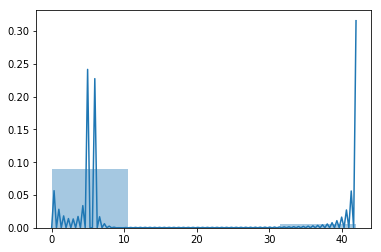

In [144]:
test_hist = cv2.calcHist([imgs[]],
             [0],
             masks_bin[2].astype(np.uint8),
             [16],
             [0, 255]).flatten()
sns.distplot(test_hist)

In [134]:
cd = ColorDescriptor([32])

hists = []
for img, mask in zip(imgs, masks_bin):
#     hists.append(cd.describe(img, None))
    hists.append(cd.describe(img, mask.astype(np.uint8)))

In [185]:
img_diffs = []
for i in range(len(imgs)):
    img_diffs.append(np.diff(imgs[i].astype(np.float32), axis=-1))

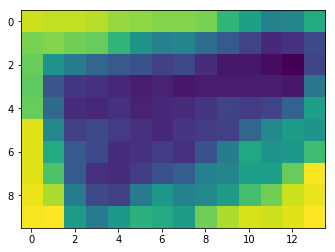

In [198]:
plt.imshow(img_diffs[0][:, :, 7])

In [135]:
hists_1 = np.array(hists)[train_df['Crop_Id_Ne']  == '1']
hists_8 = np.array(hists)[train_df['Crop_Id_Ne']  == '8']
hists_9 = np.array(hists)[train_df['Crop_Id_Ne']  == '9']

In [136]:
np.array(hists).shape

(2494, 352)

In [137]:
some_dst = []
for i in range(hists_9.shape[0]):
    dist = chi2_distance(hists_1[0], hists_8[i], eps = 1e-10)
#     dist = np.linalg.norm(hists_8[0]-hists_8[i])
    some_dst.append(dist)

(array([21., 25., 11.,  5.,  3.,  4.,  2.,  2.,  1.,  2.]),
 array([ 188.14489384,  339.52322685,  490.90155987,  642.27989289,
         793.6582259 ,  945.03655892, 1096.41489194, 1247.79322496,
        1399.17155797, 1550.54989099, 1701.92822401]),
 <a list of 10 Patch objects>)

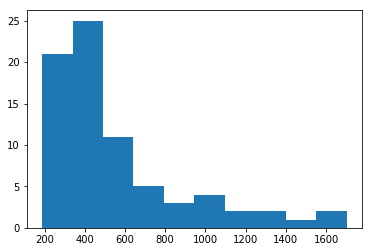

In [138]:
plt.hist(some_dst[1:])

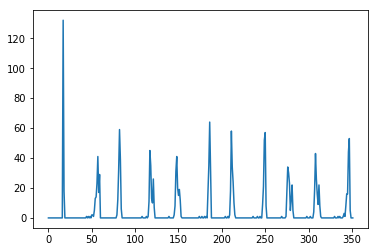

In [159]:
plt.plot(hists[10])

In [160]:
from sklearn.ensemble import RandomForestClassifier

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [161]:
rf = RandomForestClassifier(n_estimators=100)

In [162]:
cross_val_score(rf, hists, labels, cv=5, n_jobs=-1, verbose=3)

[CV]  ................................................................
[CV] ....................... , score=0.4503968253968254, total=   0.9s
[CV]  ................................................................
[CV] ...................... , score=0.43313373253493015, total=   1.2s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.6s remaining:   14.4s


[CV]  ................................................................
[CV] ....................... , score=0.4225352112676056, total=   1.0s
[CV]  ................................................................
[CV] ....................... , score=0.4495967741935484, total=   0.9s
[CV]  ................................................................
[CV] ....................... , score=0.4778225806451613, total=   0.9s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished


array([0.45039683, 0.43313373, 0.42253521, 0.44959677, 0.47782258])

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


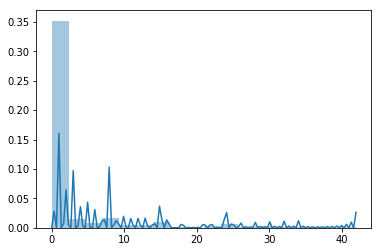

In [145]:
sns.distplot(hists[0])

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


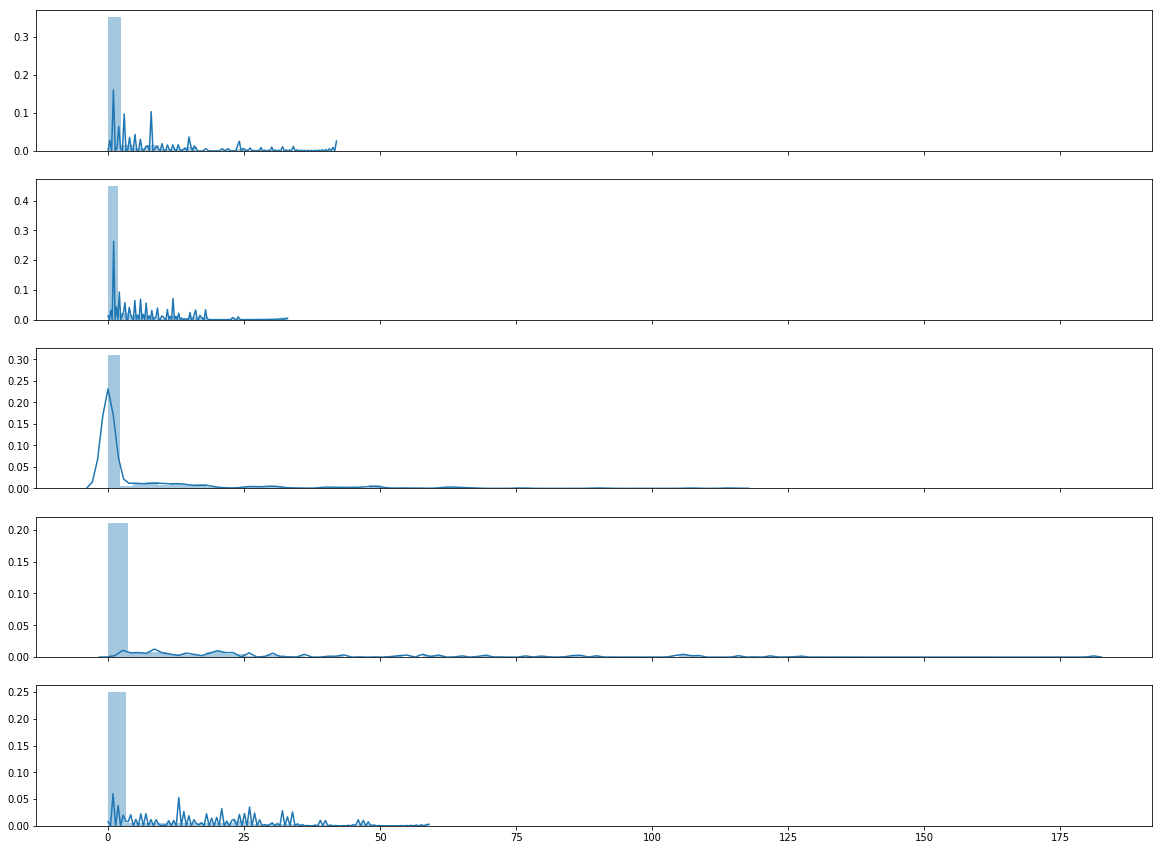

In [141]:
# plot

f, axes = plt.subplots(len(hists_8[:5]), 1, figsize=(20, 15), sharex=True)
for num, i in enumerate(hists_8[:5]):
    sns.distplot(i, ax=axes[num])

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


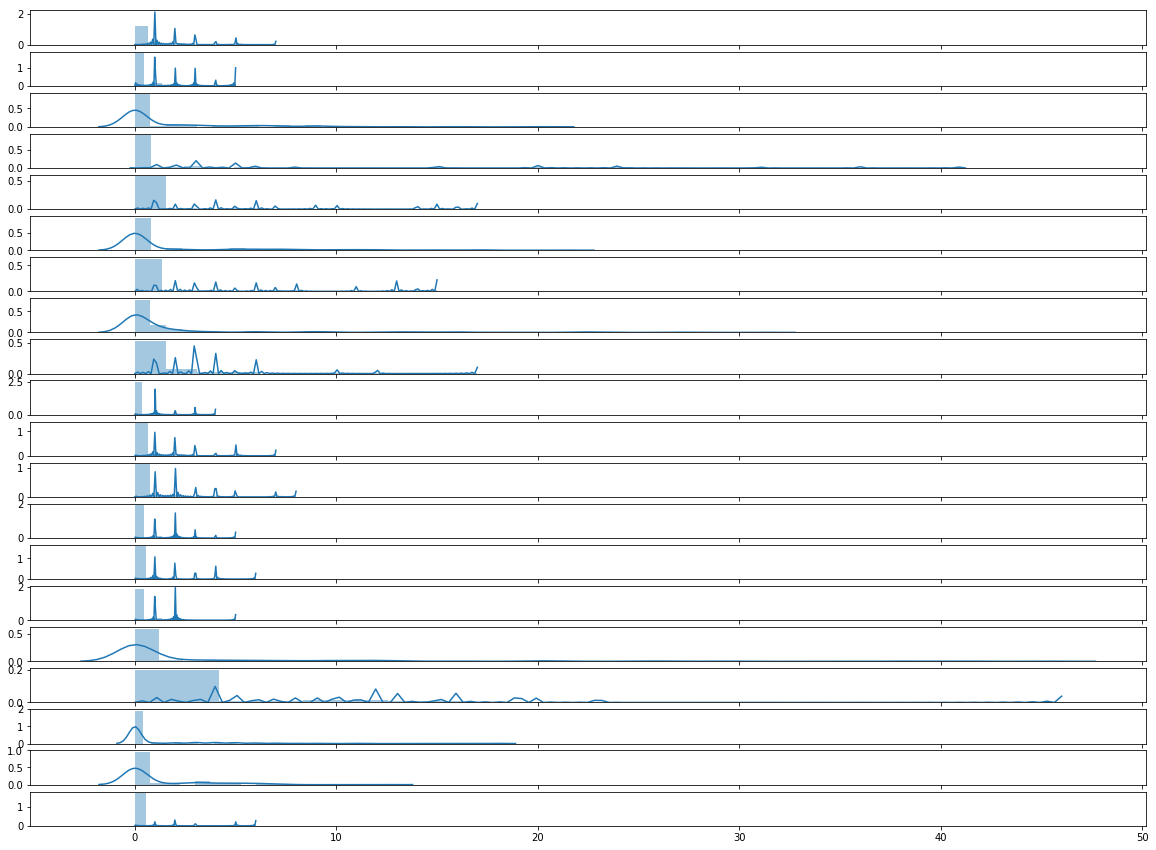

In [75]:
# plot

f, axes = plt.subplots(len(hists_8[:20]), 1, figsize=(20, 15), sharex=True)
for num, i in enumerate(hists_8[:20]):
    sns.distplot(i, ax=axes[num])


In [17]:
def chi2_distance(histA, histB, eps = 1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    # return the chi-squared distance
    return d

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [19]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    lbls = unique_labels(y_true, y_pred)
    lbls = [int(lbl) - 1 for lbl in lbls]
    classes = classes[lbls]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [20]:
len(hists[0])

176

In [357]:
neigh = KNeighborsClassifier(n_neighbors=3, metric=chi2_distance)

cross_val_score(neigh, hists, labels, cv=5, n_jobs=-1, verbose=3)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=0.3333333333333333, total= 1.5min
[CV] ...................... , score=0.32595573440643866, total= 1.5min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min


[CV] ....................... , score=0.3413173652694611, total= 1.5min
[CV] ....................... , score=0.4012096774193548, total= 1.5min
[CV] ....................... , score=0.4274193548387097, total= 1.5min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


array([0.33333333, 0.34131737, 0.32595573, 0.40120968, 0.42741935])

In [358]:
from sklearn.model_selection import train_test_split

In [359]:
X_train, X_test, y_train, y_test = train_test_split(
    hists, labels, test_size=0.2, random_state=42)

In [360]:
neigh = KNeighborsClassifier(n_neighbors=3, metric=chi2_distance, n_jobs=-1)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function chi2_distance at 0x7f810dd7b048>,
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')

In [361]:
y_pred = neigh.predict(X_test[:500])

In [362]:
y_test = y_test[:500]

In [363]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.4649298597194389

In [364]:
# class_names = pd.read_csv("/home/user/projects/africa_starving/data/crop_id_list.csv")
class_names = pd.read_csv("/mnt/storage_4tb/ymi/crop_detection/Africa/data/crop_id_list.csv")

In [365]:
class_names['crop'].values

array(['Cotton', 'Dates', 'Grass', 'Lucern', 'Maize', 'Pecan', 'Vacant',
       'Vineyard', 'Vineyard & Pecan ("Intercrop")'], dtype=object)

Confusion matrix, without normalization
[[ 10   0   0   4   0   0   3   2   0]
 [  0   0   1   0   0   0   0   0   1]
 [  2   0   5   1   1   0   0   5   0]
 [  3   0   4  63   4   1   0  30   0]
 [  5   1   4  17  26   0   3  17   1]
 [  2   1   1   4   1   8   1  15   0]
 [  7   0   4  12   3   2   7  21   0]
 [ 13   0   4  33  13   3   5 112   1]
 [  0   0   1   2   0   0   0   8   1]]
Normalized confusion matrix
[[0.52631579 0.         0.         0.21052632 0.         0.
  0.15789474 0.10526316 0.        ]
 [0.         0.         0.5        0.         0.         0.
  0.         0.         0.5       ]
 [0.14285714 0.         0.35714286 0.07142857 0.07142857 0.
  0.         0.35714286 0.        ]
 [0.02857143 0.         0.03809524 0.6        0.03809524 0.00952381
  0.         0.28571429 0.        ]
 [0.06756757 0.01351351 0.05405405 0.22972973 0.35135135 0.
  0.04054054 0.22972973 0.01351351]
 [0.06060606 0.03030303 0.03030303 0.12121212 0.03030303 0.24242424
  0.03030303 0.45454545 

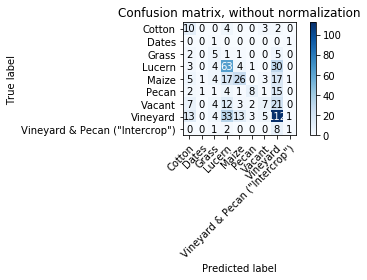

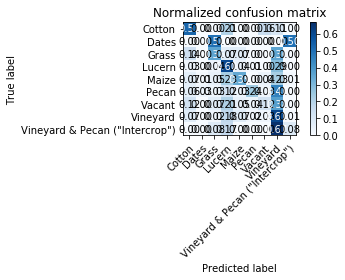

In [366]:
# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names['crop'].values,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names['crop'].values, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
hists[0].shape